## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
from model import LSTMModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset

## Exploring Data

In [18]:
df = pd.read_csv("data/monatszahlen2412_verkehrsunfaelle_06_12_24.csv", usecols=["MONATSZAHL", "AUSPRAEGUNG", "JAHR", "MONAT", "WERT"])
df

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
0,Alkoholunfälle,insgesamt,2024,202401,NaN
1,Alkoholunfälle,insgesamt,2024,202402,NaN
2,Alkoholunfälle,insgesamt,2024,202403,NaN
3,Alkoholunfälle,insgesamt,2024,202404,NaN
4,Alkoholunfälle,insgesamt,2024,202405,NaN
...,...,...,...,...,...
2249,Verkehrsunfälle,Verletzte und Getötete,2000,200008,647.0
2250,Verkehrsunfälle,Verletzte und Getötete,2000,200009,675.0
2251,Verkehrsunfälle,Verletzte und Getötete,2000,200010,615.0
2252,Verkehrsunfälle,Verletzte und Getötete,2000,200011,578.0


### Filtering Data

In [4]:
# Removing Data after 2020
filtered_df= df[df['JAHR']<=2020]

# Filter the data for 'Alkoholunfälle' and 'insgesamt'
filtered_df = filtered_df[
    (filtered_df["MONATSZAHL"] == "Alkoholunfälle") &
    (filtered_df["AUSPRAEGUNG"] == "insgesamt")
]

filtered_df

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
50,Alkoholunfälle,insgesamt,2020,Summe,430.0
51,Alkoholunfälle,insgesamt,2020,202001,28.0
52,Alkoholunfälle,insgesamt,2020,202002,40.0
53,Alkoholunfälle,insgesamt,2020,202003,27.0
54,Alkoholunfälle,insgesamt,2020,202004,26.0
...,...,...,...,...,...
317,Alkoholunfälle,insgesamt,2000,200008,77.0
318,Alkoholunfälle,insgesamt,2000,200009,84.0
319,Alkoholunfälle,insgesamt,2000,200010,83.0
320,Alkoholunfälle,insgesamt,2000,200011,71.0


In [6]:
unique_months = filtered_df["MONAT"].unique()
unique_months

array(['Summe', '202001', '202002', '202003', '202004', '202005',
       '202006', '202007', '202008', '202009', '202010', '202011',
       '202012', '201901', '201902', '201903', '201904', '201905',
       '201906', '201907', '201908', '201909', '201910', '201911',
       '201912', '201801', '201802', '201803', '201804', '201805',
       '201806', '201807', '201808', '201809', '201810', '201811',
       '201812', '201701', '201702', '201703', '201704', '201705',
       '201706', '201707', '201708', '201709', '201710', '201711',
       '201712', '201601', '201602', '201603', '201604', '201605',
       '201606', '201607', '201608', '201609', '201610', '201611',
       '201612', '201501', '201502', '201503', '201504', '201505',
       '201506', '201507', '201508', '201509', '201510', '201511',
       '201512', '201401', '201402', '201403', '201404', '201405',
       '201406', '201407', '201408', '201409', '201410', '201411',
       '201412', '201301', '201302', '201303', '201304', '20130

In [7]:
#non-integer months
non_integer_months = [month for month in unique_months if not month.isdigit()]
non_integer_months
# Remove non-integer months from the filtered dataframe
filtered_df = filtered_df[~filtered_df["MONAT"].isin(non_integer_months)]

#Convert strind data to int
filtered_df['JAHR'] = filtered_df['JAHR'].astype(int)
filtered_df['MONAT'] = filtered_df['MONAT'].astype(int)

filtered_df

/var/folders/dy/s4zzkv9s7450s4lpchg99gsw0000gn/T/ipykernel_29311/1173133832.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['JAHR'] = filtered_df['JAHR'].astype(int)
/var/folders/dy/s4zzkv9s7450s4lpchg99gsw0000gn/T/ipykernel_29311/1173133832.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['MONAT'] = filtered_df['MONAT'].astype(int)


,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
51,Alkoholunfälle,insgesamt,2020,202001,28.0
52,Alkoholunfälle,insgesamt,2020,202002,40.0
53,Alkoholunfälle,insgesamt,2020,202003,27.0
54,Alkoholunfälle,insgesamt,2020,202004,26.0
55,Alkoholunfälle,insgesamt,2020,202005,40.0
...,...,...,...,...,...
317,Alkoholunfälle,insgesamt,2000,200008,77.0
318,Alkoholunfälle,insgesamt,2000,200009,84.0
319,Alkoholunfälle,insgesamt,2000,200010,83.0
320,Alkoholunfälle,insgesamt,2000,200011,71.0


### Normalizing value column

In [8]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(filtered_df[["WERT"]])

### Preparing Sequence

In [9]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # Use Year and Month as input features (exclude last column)
        y.append(data[i+seq_length, -1])    # Target: Value (last column)
    return np.array(X), np.array(y)


In [10]:
print(filtered_df.dtypes)


MONATSZAHL      object
AUSPRAEGUNG     object
JAHR             int64
MONAT            int64
WERT           float64
dtype: object


### Preparing data for training

In [11]:
# Convert 'MONAT' column to numeric values

# Convert to NumPy arrays
data_combined = np.column_stack([filtered_df[['JAHR', 'MONAT']].values, data_scaled])

seq_length = 12  # For monthly data, you might want to use a window of 12 months (1 year)
X, y = create_sequences(data_combined, seq_length)

# Check the shape of X and y
print(X.shape)  # Should be (num_sequences, seq_length, input_size)

# Step 5: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Convert to PyTorch tensors
X_train, y_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train)
X_test, y_test = torch.FloatTensor(X_test), torch.FloatTensor(y_test)

# Check shapes again
print(X_train.shape)  # Should be (num_train_sequences, seq_length, input_size)
print(y_train.shape)



(240, 12, 2)
torch.Size([192, 12, 2])
torch.Size([192])


## Training the Model
Here I will be using RNN LSTM model for Time-sequence Forcasting

### Hyper Paramters

In [12]:
# Initialize model, loss, and optimizer
input_size = X_train.shape[2]  # 'Year' and 'Month' as input features
hidden_size = 64
output_size = 1
num_layers = 3
batch_size = 32

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training

In [13]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 100  # Increased number of epochs
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


/Users/nullhawk/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/nullhawk/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100] - Training Loss: 0.0363, Test Loss: 0.0276
Epoch [20/100] - Training Loss: 0.0365, Test Loss: 0.0276
Epoch [30/100] - Training Loss: 0.0367, Test Loss: 0.0277
Epoch [40/100] - Training Loss: 0.0364, Test Loss: 0.0281
Epoch [50/100] - Training Loss: 0.0363, Test Loss: 0.0280
Epoch [60/100] - Training Loss: 0.0362, Test Loss: 0.0277
Epoch [70/100] - Training Loss: 0.0364, Test Loss: 0.0286
Epoch [80/100] - Training Loss: 0.0374, Test Loss: 0.0276
Epoch [90/100] - Training Loss: 0.0363, Test Loss: 0.0279
Epoch [100/100] - Training Loss: 0.0370, Test Loss: 0.0277


### Saving the Checkpoint

In [14]:
torch.save(model.state_dict(), 'checkpoints/model_checkpoint.pth')


### Model Evaluation

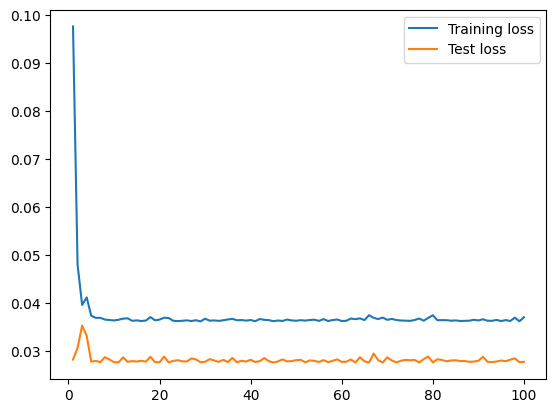

In [15]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

### Make prediction

In [16]:

# Function to make predictions
def make_prediction(year, month):
    # Load the dataset
    df = pd.read_csv("data/monatszahlen2412_verkehrsunfaelle_06_12_24.csv", usecols=["MONATSZAHL", "AUSPRAEGUNG", "JAHR", "MONAT", "WERT"])
    
    # Filtering Data
    filtered_df = df[df['JAHR'] <= 2020]
    filtered_df = filtered_df[(filtered_df["MONATSZAHL"] == "Alkoholunfälle") & (filtered_df["AUSPRAEGUNG"] == "insgesamt")]
    
    unique_months = filtered_df["MONAT"].unique()
    
    # Remove non-integer months
    non_integer_months = [month for month in unique_months if not month.isdigit()]
    filtered_df = filtered_df[~filtered_df["MONAT"].isin(non_integer_months)]

    # Convert 'JAHR' and 'MONAT' to integers
    filtered_df['JAHR'] = filtered_df['JAHR'].astype(int)
    filtered_df['MONAT'] = filtered_df['MONAT'].astype(int)
    
    # Normalize the 'WERT' column
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(filtered_df[["WERT"]])

    # Prepare data for the model (create sequences)
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length, :-1])  # Use Year and Month as input features (exclude last column)
            y.append(data[i+seq_length, -1])    # Target: Value (last column)
        return np.array(X), np.array(y)

    data_combined = np.column_stack([filtered_df[['JAHR', 'MONAT']].values, data_scaled])
    seq_length = 12  # Use the last 12 months as the input sequence
    X, y = create_sequences(data_combined, seq_length)

    # Prepare model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(input_size=2, hidden_size=64, output_size=1, num_layers=3)
    model.load_state_dict(torch.load('checkpoints/model_checkpoint.pth'))
    model = model.to(device)
    model.eval()  # Set model to evaluation mode

    # Convert input into a sequence for prediction
    input_sequence = np.array([[year, month]])  # Year and Month as input
    input_sequence = input_sequence  # Use only Year and Month as input features
    input_sequence = torch.FloatTensor(input_sequence).unsqueeze(0).to(device)

    # Make the prediction
    with torch.no_grad():
        prediction = model(input_sequence)
        prediction_rescaled = scaler.inverse_transform(np.column_stack([np.zeros((prediction.shape[0], 2)), prediction.cpu().numpy()]))
        predicted_value = prediction_rescaled[:, -1]  # The predicted 'WERT' value

    # Return the prediction in the desired format
    return {"prediction": predicted_value[0]}

# Example usage
year = 2020
month = 10
prediction = make_prediction(year, month)
print(prediction)


{'prediction': np.float64(18.38958615809679)}


/var/folders/dy/s4zzkv9s7450s4lpchg99gsw0000gn/T/ipykernel_29311/701586498.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints

In [17]:
make_prediction(2023, 9)

/var/folders/dy/s4zzkv9s7450s4lpchg99gsw0000gn/T/ipykernel_29311/701586498.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints

{'prediction': np.float64(18.389070868492126)}